In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.preprocessing import  OneHotEncoder , StandardScaler , MinMaxScaler
from scipy.stats import chi2_contingency
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
Titanic_dataset=pd.read_csv('titanic_train.csv')

In [3]:
Titanic_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
Titanic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
Titanic_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [6]:
Titanic_dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
Titanic_dataset.drop_duplicates(keep="first" , inplace=True)

In [8]:
# Drop unnecessary columns
Titanic_dataset.drop(columns=['PassengerId' , 'Name' , 'Cabin' , 'Ticket'] , inplace=True )

In [9]:
# what percentage are survived and unsurvived
percentage = Titanic_dataset["Survived"].value_counts(normalize=True) * 100
percentage

0    61.616162
1    38.383838
Name: Survived, dtype: float64

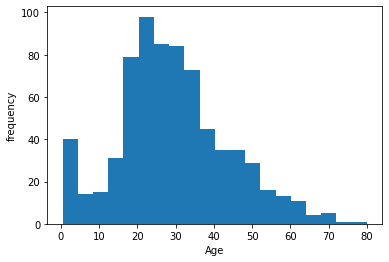

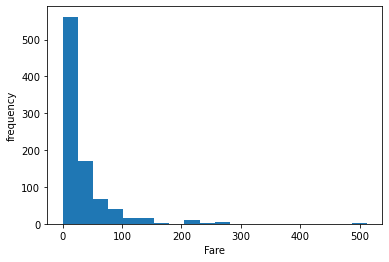

In [10]:
numerical_var=["Age" , 'Fare']
for col in numerical_var:
    plt.hist(data=Titanic_dataset , x=col, bins=20)
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.show()

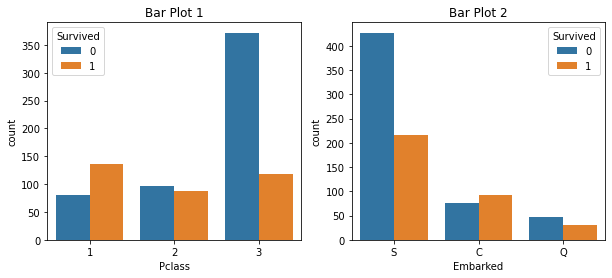

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.countplot(x="Pclass" , hue='Survived' , data=Titanic_dataset, ax=axes[0])
axes[0].set_title('Bar Plot 1')
sns.countplot(x="Embarked" , hue='Survived' , data=Titanic_dataset , ax=axes[1])
axes[1].set_title('Bar Plot 2')
plt.show()

In [12]:
Titanic_dataset.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<AxesSubplot:>

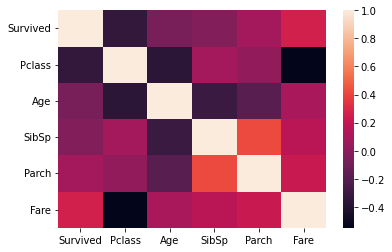

In [13]:
sns.heatmap(Titanic_dataset.corr())

In [14]:
survival_rates = Titanic_dataset.groupby('Pclass')['Survived'].mean()
chi2, p_value, _, _ = stats.chi2_contingency(Titanic_dataset.groupby(['Pclass', 'Survived']).size().unstack())
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in survival rates between passenger classes.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in survival rates between passenger classes.")
print(survival_rates)

Reject the null hypothesis. There is a significant difference in survival rates between passenger classes.
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [15]:
survivors = Titanic_dataset[Titanic_dataset['Survived'] == 1]['Fare']
non_survivors = Titanic_dataset[Titanic_dataset['Survived'] == 0]['Fare']

t_statistic, p_value = stats.ttest_ind(survivors.dropna(), non_survivors.dropna(), equal_var=False)
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in the Fare between survivors and non-survivors.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the Fare between survivors and non-survivors.")

print("Mean Age - Survivors:", survivors.mean())
print("Mean Age - Non-survivors:", non_survivors.mean())

Reject the null hypothesis. There is a significant difference in the Fare between survivors and non-survivors.
Mean Age - Survivors: 48.39540760233917
Mean Age - Non-survivors: 22.117886885245877


In [16]:
def fill_missing_value(dataset , feature , value):
    return dataset[feature].fillna(value  )
Titanic_dataset["Age"]=fill_missing_value(Titanic_dataset , 'Age' , Titanic_dataset['Age'].median())
Titanic_dataset['Embarked']=fill_missing_value(Titanic_dataset , 'Embarked' ,'S')

In [17]:
def Family_size(dataset , col1 , col2):
    return dataset[col1] + dataset [col2] +1

Titanic_dataset["Family_Size"]=Family_size(Titanic_dataset , 'SibSp' , 'Parch' )
Titanic_dataset.drop(columns=['SibSp' , 'Parch' ] , inplace=True )

In [18]:
Titanic_dataset["Family_Size"] = Titanic_dataset["Family_Size"].map({1:'alone', 2:'small' , 3:'small', 4:'medium' , 
                                                                    5:'medium' , 6:'medium', 7:'large' , 8:'large' , 11:'large'})

In [19]:
y=Titanic_dataset["Survived"]
X=Titanic_dataset.drop('Survived' , axis=1)
X_train, X_test , y_train , y_test=train_test_split(X , y , test_size=0.2 , random_state=42, stratify = y)

In [20]:
X_train_number=X_train.drop(columns=["Sex" , "Embarked" , 'Pclass' , 'Family_Size'])
num_list=list(X_train_number)
X_train_category=X_train[["Sex" , "Embarked" , 'Pclass']]
cat_list=list(X_train_category)
ord_list=["Family_Size"]
preprocess=ColumnTransformer([
    ('scale' , StandardScaler() , num_list),
    ('1hot' , OneHotEncoder() , cat_list),
])
X_train_pre=preprocess.fit_transform(X_train)

In [21]:
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
xgboost = XGBClassifier()

In [22]:
models = [decision_tree, random_forest, xgboost]
for model in models:
    model.fit(X_train_pre, y_train)  
    y_pred = cross_val_predict(model , X_train_pre, y_train , cv=3) 

    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    accuracy=accuracy_score(y_train, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy:{accuracy}")

Model: DecisionTreeClassifier
Precision: 0.6948529411764706
Recall: 0.6923076923076923
Accuracy:0.7654494382022472
Model: RandomForestClassifier
Precision: 0.7647058823529411
Recall: 0.7142857142857143
Accuracy:0.8061797752808989
Model: XGBClassifier
Precision: 0.7764705882352941
Recall: 0.7252747252747253
Accuracy:0.8146067415730337


In [23]:
models = {
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50 , 100, 200 , 250]}),
    'XGBoost': (XGBClassifier(), {'max_depth': [3, 5, 7,15], 'learning_rate': [ 0.5,0.1, 0.01, 0.001]})
}

In [24]:
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train_pre, y_train)  # Fit the model on the training data
    y_pred = cross_val_predict(model , X_train_pre, y_train , cv=3)  
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    accuracy=accuracy_score(y_train, y_pred)
    print(f"Model: {model_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy:{accuracy}")

Model: Decision Tree
Best Parameters: {'max_depth': 5}
Precision: 0.7052238805970149
Recall: 0.6923076923076923
Accuracy:0.7710674157303371
Model: Random Forest
Best Parameters: {'n_estimators': 250}
Precision: 0.7635658914728682
Recall: 0.7216117216117216
Accuracy:0.8075842696629213
Model: XGBoost
Best Parameters: {'learning_rate': 0.01, 'max_depth': 15}
Precision: 0.7764705882352941
Recall: 0.7252747252747253
Accuracy:0.8146067415730337
